In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

from ttictoc import TicToc

# Get MNIST

## 8. Deep Learning

### 8.1.

_Exercise: Build a DNN with five hidden layers of 100 neurons each, He initialization, and the ELU activation function._







### 8.2.

_Exercise: Using Adam optimization and early stopping, try training it on MNIST but only on digits 0 to 4, as we will use transfer learning for digits 5 to 9 in the next exercise. You will need a softmax output layer with five neurons, and as always make sure to save checkpoints at regular intervals and save the final model so you can reuse it later._







### 8.3.

_Exercise: Tune the hyperparameters using cross-validation and see what precision you can achieve._







### 8.4.

_Exercise: Now try adding Batch Normalization and compare the learning curves: is it converging faster than before? Does it produce a better model?_







### 8.5.

_Exercise: is the model overfitting the training set? Try adding dropout to every layer and try again. Does it help?_







## 9. Transfer learning

### 9.1.

_Exercise: create a new DNN that reuses all the pretrained hidden layers of the previous model, freezes them, and replaces the softmax output layer with a new one._







### 9.2.

_Exercise: train this new DNN on digits 5 to 9, using only 100 images per digit, and time how long it takes. Despite this small number of examples, can you achieve high precision?_







### 9.3.

_Exercise: try caching the frozen layers, and train the model again: how much faster is it now?_







### 9.4.

_Exercise: try again reusing just four hidden layers instead of five. Can you achieve a higher precision?_







### 9.5.

_Exercise: now unfreeze the top two hidden layers and continue training: can you get the model to perform even better?_







## 10. Pretraining on an auxiliary task

In this exercise you will build a DNN that compares two MNIST digit images and predicts whether they represent the same digit or not. Then you will reuse the lower layers of this network to train an MNIST classifier using very little training data.

### 10.1.
Exercise: _Start by building two DNNs (let's call them DNN A and B), both similar to the one you built earlier but without the output layer: each DNN should have five hidden layers of 100 neurons each, He initialization, and ELU activation. Next, add one more hidden layer with 10 units on top of both DNNs. You should use the `keras.layers.concatenate()` function to concatenate the outputs of both DNNs, then feed the result to the hidden layer. Finally, add an output layer with a single neuron using the logistic activation function._







### 10.2.
_Exercise: split the MNIST training set in two sets: split #1 should containing 55,000 images, and split #2 should contain contain 5,000 images. Create a function that generates a training batch where each instance is a pair of MNIST images picked from split #1. Half of the training instances should be pairs of images that belong to the same class, while the other half should be images from different classes. For each pair, the training label should be 0 if the images are from the same class, or 1 if they are from different classes._







### 10.3.
_Exercise: train the DNN on this training set. For each image pair, you can simultaneously feed the first image to DNN A and the second image to DNN B. The whole network will gradually learn to tell whether two images belong to the same class or not._







### 10.4.
_Exercise: now create a new DNN by reusing and freezing the hidden layers of DNN A and adding a softmax output layer on top with 10 neurons. Train this network on split #2 and see if you can achieve high performance despite having only 500 images per class._







# Question 8

## 8.1

In [17]:
def build_model(n_hidden=5, n_neurons=100, learning_rate=3e-3,
                input_shape=[28, 28], output=5, batch_norm=False,
                dropout=False, dropout_rate=0.2):
    # Build
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="elu", kernel_initializer='he_uniform'))
        if batch_norm:
            model.add(keras.layers.BatchNormalization())
        if dropout:
            model.add(keras.layers.Dropout(rate=dropout_rate))
    model.add(keras.layers.Dense(output, activation="softmax", kernel_initializer='he_uniform'))
    # Compile
    optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [3]:
model = build_model()

## 8.2


In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

# Index of 0, 1, 2, 3, 4
idx = (y_train_full==0)\
    + (y_train_full==1)\
    + (y_train_full==2)\
    + (y_train_full==3)\
    + (y_train_full==4)
y_train_sub_full = y_train_full[idx]
X_train_sub_full = X_train_full[idx]

# Get training and Validation (only 3000 points now cause full set is 30000)
X_valid_sub, X_train_sub = X_train_sub_full[:3000], X_train_sub_full[3000:]
y_valid_sub, y_train_sub = y_train_sub_full[:3000], y_train_sub_full[3000:]

In [5]:
# Checkpoints
checkpoint_cb = keras.callbacks.ModelCheckpoint("chap11_q8_model1.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Train
history = model.fit(X_train_sub, y_train_sub, epochs=1000,
                    validation_data=(X_valid_sub, y_valid_sub),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Train on 27596 samples, validate on 3000 samples
Epoch 1/1000
27596/27596 [==============================] - 3s 98us/sample - loss: 0.1123 - accuracy: 0.9656 - val_loss: 0.0765 - val_accuracy: 0.9760
Epoch 2/1000
27596/27596 [==============================] - 2s 71us/sample - loss: 0.0553 - accuracy: 0.9829 - val_loss: 0.0564 - val_accuracy: 0.9817
Epoch 3/1000
27596/27596 [==============================] - 2s 70us/sample - loss: 0.0424 - accuracy: 0.9866 - val_loss: 0.0555 - val_accuracy: 0.9843
Epoch 4/1000
27596/27596 [==============================] - 2s 70us/sample - loss: 0.0330 - accuracy: 0.9897 - val_loss: 0.0414 - val_accuracy: 0.9880
Epoch 5/1000
27596/27596 [==============================] - ETA: 0s - loss: 0.0256 - accuracy: 0.99 - 2s 72us/sample - loss: 0.0257 - accuracy: 0.9918 - val_loss: 0.0470 - val_accuracy: 0.9877
Epoch 6/1000
27596/27596 [==============================] - 2s 72us/sample - loss: 0.0215 - accuracy: 0.9926 - val_loss: 0.0555 - val_accuracy: 0.9850
Epo

## 8.3

In [6]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

Do some cross validation

In [7]:
param_distribs = {
    "n_hidden": [3, 4, 5, 6],
    "n_neurons": np.arange(50, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train_sub, y_train_sub, epochs=100,
                  validation_data=(X_valid_sub, y_valid_sub),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] learning_rate=0.0008872124640015472, n_hidden=5, n_neurons=66 ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train on 18397 samples, validate on 3000 samples
Epoch 1/100
18397/18397 [==============================] - 2s 87us/sample - loss: 0.1345 - accuracy: 0.9574 - val_loss: 0.0745 - val_accuracy: 0.9770
Epoch 2/100
18397/18397 [==============================] - 1s 62us/sample - loss: 0.0606 - accuracy: 0.9810 - val_loss: 0.0682 - val_accuracy: 0.9807
Epoch 3/100
18397/18397 [==============================] - 1s 61us/sample - loss: 0.0427 - accuracy: 0.9862 - val_loss: 0.0524 - val_accuracy: 0.9830
Epoch 4/100
18397/18397 [==============================] - 1s 62us/sample - loss: 0.0277 - accuracy: 0.9912 - val_loss: 0.0598 - val_accuracy: 0.9830
Epoch 5/100
18397/18397 [==============================] - 1s 65us/sample - loss: 0.0255 - accuracy: 0.9919 - val_loss: 0.0693 - val_accuracy: 0.9803
Epoch 6/100
18397/18397 [==============================] - 1s 67us/sample - loss: 0.0195 - accuracy: 0.9937 - val_loss: 0.0481 - val_accuracy: 0.9850
Epoch 7/100
18397/18397 [==========================

[CV]  learning_rate=0.0008872124640015472, n_hidden=5, n_neurons=66, total=  30.3s
[CV] learning_rate=0.0008872124640015472, n_hidden=5, n_neurons=66 ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.2s remaining:    0.0s


Train on 18397 samples, validate on 3000 samples
Epoch 1/100
18397/18397 [==============================] - 2s 126us/sample - loss: 0.1283 - accuracy: 0.9587 - val_loss: 0.0751 - val_accuracy: 0.9747
Epoch 2/100
18397/18397 [==============================] - 2s 104us/sample - loss: 0.0576 - accuracy: 0.9811 - val_loss: 0.0708 - val_accuracy: 0.9763
Epoch 3/100
18397/18397 [==============================] - 2s 88us/sample - loss: 0.0410 - accuracy: 0.9856 - val_loss: 0.0466 - val_accuracy: 0.9833
Epoch 4/100
18397/18397 [==============================] - 1s 75us/sample - loss: 0.0271 - accuracy: 0.9917 - val_loss: 0.0537 - val_accuracy: 0.9840
Epoch 5/100
18397/18397 [==============================] - 2s 86us/sample - loss: 0.0255 - accuracy: 0.9911 - val_loss: 0.0411 - val_accuracy: 0.9880
Epoch 6/100
18397/18397 [==============================] - 1s 69us/sample - loss: 0.0224 - accuracy: 0.9922 - val_loss: 0.0813 - val_accuracy: 0.9803
Epoch 7/100
18397/18397 [========================

[CV]  learning_rate=0.0008872124640015472, n_hidden=5, n_neurons=66, total=  23.2s
[CV] learning_rate=0.0008872124640015472, n_hidden=5, n_neurons=66 ...
Train on 18398 samples, validate on 3000 samples
Epoch 1/100
18398/18398 [==============================] - 2s 126us/sample - loss: 0.1445 - accuracy: 0.9551 - val_loss: 0.0775 - val_accuracy: 0.9743
Epoch 2/100
18398/18398 [==============================] - 1s 68us/sample - loss: 0.0625 - accuracy: 0.9803 - val_loss: 0.0665 - val_accuracy: 0.9773
Epoch 3/100
18398/18398 [==============================] - 1s 79us/sample - loss: 0.0443 - accuracy: 0.9865 - val_loss: 0.0420 - val_accuracy: 0.9867
Epoch 4/100
18398/18398 [==============================] - 1s 67us/sample - loss: 0.0289 - accuracy: 0.9906 - val_loss: 0.0440 - val_accuracy: 0.9850
Epoch 5/100
18398/18398 [==============================] - 1s 69us/sample - loss: 0.0253 - accuracy: 0.9912 - val_loss: 0.0682 - val_accuracy: 0.9797
Epoch 6/100
18398/18398 [=====================

[CV]  learning_rate=0.0008872124640015472, n_hidden=5, n_neurons=66, total=  18.8s
[CV] learning_rate=0.0025830741540388866, n_hidden=5, n_neurons=98 ...
Train on 18397 samples, validate on 3000 samples
Epoch 1/100
18397/18397 [==============================] - 2s 119us/sample - loss: 0.1253 - accuracy: 0.9608 - val_loss: 0.1286 - val_accuracy: 0.9583
Epoch 2/100
18397/18397 [==============================] - 2s 84us/sample - loss: 0.0567 - accuracy: 0.9819 - val_loss: 0.0620 - val_accuracy: 0.9833
Epoch 3/100
18397/18397 [==============================] - 1s 76us/sample - loss: 0.0436 - accuracy: 0.9859 - val_loss: 0.0450 - val_accuracy: 0.9853
Epoch 4/100
18397/18397 [==============================] - 1s 81us/sample - loss: 0.0315 - accuracy: 0.9902 - val_loss: 0.0590 - val_accuracy: 0.9837
Epoch 5/100
18397/18397 [==============================] - 1s 81us/sample - loss: 0.0246 - accuracy: 0.9914 - val_loss: 0.0549 - val_accuracy: 0.9867
Epoch 6/100
18397/18397 [=====================

[CV]  learning_rate=0.0025830741540388866, n_hidden=5, n_neurons=98, total=  31.5s
[CV] learning_rate=0.0025830741540388866, n_hidden=5, n_neurons=98 ...
Train on 18397 samples, validate on 3000 samples
Epoch 1/100
18397/18397 [==============================] - 2s 105us/sample - loss: 0.1272 - accuracy: 0.9604 - val_loss: 0.0996 - val_accuracy: 0.9723
Epoch 2/100
18397/18397 [==============================] - 1s 78us/sample - loss: 0.0576 - accuracy: 0.9821 - val_loss: 0.0825 - val_accuracy: 0.9793
Epoch 3/100
18397/18397 [==============================] - 1s 81us/sample - loss: 0.0413 - accuracy: 0.9870 - val_loss: 0.0712 - val_accuracy: 0.9810
Epoch 4/100
18397/18397 [==============================] - 1s 79us/sample - loss: 0.0346 - accuracy: 0.9884 - val_loss: 0.0690 - val_accuracy: 0.9807
Epoch 5/100
18397/18397 [==============================] - 2s 90us/sample - loss: 0.0290 - accuracy: 0.9910 - val_loss: 0.0534 - val_accuracy: 0.9830
Epoch 6/100
18397/18397 [=====================

[CV]  learning_rate=0.0025830741540388866, n_hidden=5, n_neurons=98, total=  56.2s
[CV] learning_rate=0.0025830741540388866, n_hidden=5, n_neurons=98 ...
Train on 18398 samples, validate on 3000 samples
Epoch 1/100
18398/18398 [==============================] - 2s 105us/sample - loss: 0.1312 - accuracy: 0.9592 - val_loss: 0.0745 - val_accuracy: 0.9773
Epoch 2/100
18398/18398 [==============================] - 1s 79us/sample - loss: 0.0584 - accuracy: 0.9820 - val_loss: 0.0646 - val_accuracy: 0.9820
Epoch 3/100
18398/18398 [==============================] - 1s 79us/sample - loss: 0.0446 - accuracy: 0.9857 - val_loss: 0.0570 - val_accuracy: 0.9797
Epoch 4/100
18398/18398 [==============================] - 2s 84us/sample - loss: 0.0339 - accuracy: 0.9883 - val_loss: 0.0548 - val_accuracy: 0.9843
Epoch 5/100
18398/18398 [==============================] - 2s 83us/sample - loss: 0.0319 - accuracy: 0.9892 - val_loss: 0.0468 - val_accuracy: 0.9877
Epoch 6/100
18398/18398 [=====================

[CV]  learning_rate=0.0025830741540388866, n_hidden=5, n_neurons=98, total=  32.4s
[CV] learning_rate=0.0007121894165698476, n_hidden=6, n_neurons=56 ...
Train on 18397 samples, validate on 3000 samples
Epoch 1/100
18397/18397 [==============================] - 2s 108us/sample - loss: 0.1409 - accuracy: 0.9552 - val_loss: 0.0942 - val_accuracy: 0.9697
Epoch 2/100
18397/18397 [==============================] - 1s 74us/sample - loss: 0.0648 - accuracy: 0.9805 - val_loss: 0.0595 - val_accuracy: 0.9807
Epoch 3/100
18397/18397 [==============================] - 1s 71us/sample - loss: 0.0400 - accuracy: 0.9872 - val_loss: 0.0479 - val_accuracy: 0.9850
Epoch 4/100
18397/18397 [==============================] - 1s 76us/sample - loss: 0.0345 - accuracy: 0.9889 - val_loss: 0.0621 - val_accuracy: 0.9787
Epoch 5/100
18397/18397 [==============================] - 1s 72us/sample - loss: 0.0299 - accuracy: 0.9905 - val_loss: 0.0590 - val_accuracy: 0.9830
Epoch 6/100
18397/18397 [=====================

[CV]  learning_rate=0.0007121894165698476, n_hidden=6, n_neurons=56, total=  18.7s
[CV] learning_rate=0.0007121894165698476, n_hidden=6, n_neurons=56 ...
Train on 18397 samples, validate on 3000 samples
Epoch 1/100
18397/18397 [==============================] - 2s 106us/sample - loss: 0.1348 - accuracy: 0.9569 - val_loss: 0.0937 - val_accuracy: 0.9743
Epoch 2/100
18397/18397 [==============================] - 1s 77us/sample - loss: 0.0578 - accuracy: 0.9814 - val_loss: 0.0693 - val_accuracy: 0.9773
Epoch 3/100
18397/18397 [==============================] - 1s 78us/sample - loss: 0.0417 - accuracy: 0.9866 - val_loss: 0.0667 - val_accuracy: 0.9817
Epoch 4/100
18397/18397 [==============================] - 1s 79us/sample - loss: 0.0305 - accuracy: 0.9896 - val_loss: 0.0571 - val_accuracy: 0.9823
Epoch 5/100
18397/18397 [==============================] - 1s 73us/sample - loss: 0.0251 - accuracy: 0.9918 - val_loss: 0.0627 - val_accuracy: 0.9800
Epoch 6/100
18397/18397 [=====================

[CV]  learning_rate=0.0007121894165698476, n_hidden=6, n_neurons=56, total=  36.8s
[CV] learning_rate=0.0007121894165698476, n_hidden=6, n_neurons=56 ...
Train on 18398 samples, validate on 3000 samples
Epoch 1/100
18398/18398 [==============================] - 2s 98us/sample - loss: 0.1437 - accuracy: 0.9546 - val_loss: 0.0695 - val_accuracy: 0.9753
Epoch 2/100
18398/18398 [==============================] - ETA: 0s - loss: 0.0585 - accuracy: 0.98 - 1s 68us/sample - loss: 0.0595 - accuracy: 0.9808 - val_loss: 0.0729 - val_accuracy: 0.9773
Epoch 3/100
18398/18398 [==============================] - 1s 69us/sample - loss: 0.0433 - accuracy: 0.9858 - val_loss: 0.0505 - val_accuracy: 0.9823
Epoch 4/100
18398/18398 [==============================] - 1s 70us/sample - loss: 0.0383 - accuracy: 0.9868 - val_loss: 0.0477 - val_accuracy: 0.9847
Epoch 5/100
18398/18398 [==============================] - 1s 69us/sample - loss: 0.0252 - accuracy: 0.9917 - val_loss: 0.0500 - val_accuracy: 0.9847
Epoch

[CV]  learning_rate=0.0007121894165698476, n_hidden=6, n_neurons=56, total=  36.5s
[CV] learning_rate=0.02019226452593498, n_hidden=5, n_neurons=53 .....
Train on 18397 samples, validate on 3000 samples
Epoch 1/100
18397/18397 [==============================] - 2s 101us/sample - loss: 0.1382 - accuracy: 0.9574 - val_loss: 0.0814 - val_accuracy: 0.9737
Epoch 2/100
18397/18397 [==============================] - 1s 67us/sample - loss: 0.0548 - accuracy: 0.9828 - val_loss: 0.0617 - val_accuracy: 0.9797
Epoch 3/100
18397/18397 [==============================] - 1s 72us/sample - loss: 0.0438 - accuracy: 0.9864 - val_loss: 0.0478 - val_accuracy: 0.9843
Epoch 4/100
18397/18397 [==============================] - 1s 71us/sample - loss: 0.0299 - accuracy: 0.9898 - val_loss: 0.0529 - val_accuracy: 0.9810
Epoch 5/100
18397/18397 [==============================] - 1s 68us/sample - loss: 0.0249 - accuracy: 0.9918 - val_loss: 0.0492 - val_accuracy: 0.9853
Epoch 6/100
18397/18397 [=====================

[CV]  learning_rate=0.02019226452593498, n_hidden=5, n_neurons=53, total=  17.8s
[CV] learning_rate=0.02019226452593498, n_hidden=5, n_neurons=53 .....
Train on 18397 samples, validate on 3000 samples
Epoch 1/100
18397/18397 [==============================] - 2s 96us/sample - loss: 0.1376 - accuracy: 0.9564 - val_loss: 0.1072 - val_accuracy: 0.9627
Epoch 2/100
18397/18397 [==============================] - 1s 72us/sample - loss: 0.0609 - accuracy: 0.9812 - val_loss: 0.0650 - val_accuracy: 0.9800
Epoch 3/100
18397/18397 [==============================] - 1s 74us/sample - loss: 0.0388 - accuracy: 0.9874 - val_loss: 0.0570 - val_accuracy: 0.9817
Epoch 4/100
18397/18397 [==============================] - 2s 83us/sample - loss: 0.0274 - accuracy: 0.9904 - val_loss: 0.0671 - val_accuracy: 0.9800
Epoch 5/100
18397/18397 [==============================] - 1s 66us/sample - loss: 0.0262 - accuracy: 0.9915 - val_loss: 0.0541 - val_accuracy: 0.9837
Epoch 6/100
18397/18397 [========================

[CV]  learning_rate=0.02019226452593498, n_hidden=5, n_neurons=53, total=  25.5s
[CV] learning_rate=0.02019226452593498, n_hidden=5, n_neurons=53 .....
Train on 18398 samples, validate on 3000 samples
Epoch 1/100
18398/18398 [==============================] - 2s 101us/sample - loss: 0.1354 - accuracy: 0.9568 - val_loss: 0.0854 - val_accuracy: 0.9700
Epoch 2/100
18398/18398 [==============================] - 1s 68us/sample - loss: 0.0579 - accuracy: 0.9826 - val_loss: 0.0485 - val_accuracy: 0.9827
Epoch 3/100
18398/18398 [==============================] - 1s 66us/sample - loss: 0.0410 - accuracy: 0.9865 - val_loss: 0.0703 - val_accuracy: 0.9813
Epoch 4/100
18398/18398 [==============================] - 1s 64us/sample - loss: 0.0349 - accuracy: 0.9883 - val_loss: 0.0574 - val_accuracy: 0.9810
Epoch 5/100
18398/18398 [==============================] - 1s 64us/sample - loss: 0.0246 - accuracy: 0.9916 - val_loss: 0.0477 - val_accuracy: 0.9843
Epoch 6/100
18398/18398 [=======================

[CV]  learning_rate=0.02019226452593498, n_hidden=5, n_neurons=53, total=  26.6s
[CV] learning_rate=0.0009677475258864826, n_hidden=6, n_neurons=85 ...
Train on 18397 samples, validate on 3000 samples
Epoch 1/100
18397/18397 [==============================] - 2s 111us/sample - loss: 0.1284 - accuracy: 0.9595 - val_loss: 0.0947 - val_accuracy: 0.9720
Epoch 2/100
18397/18397 [==============================] - 2s 91us/sample - loss: 0.0580 - accuracy: 0.9822 - val_loss: 0.0664 - val_accuracy: 0.9780
Epoch 3/100
18397/18397 [==============================] - 2s 89us/sample - loss: 0.0467 - accuracy: 0.9853 - val_loss: 0.0676 - val_accuracy: 0.9817
Epoch 4/100
18397/18397 [==============================] - 1s 77us/sample - loss: 0.0357 - accuracy: 0.9882 - val_loss: 0.0610 - val_accuracy: 0.9820
Epoch 5/100
18397/18397 [==============================] - 1s 77us/sample - loss: 0.0316 - accuracy: 0.9903 - val_loss: 0.0363 - val_accuracy: 0.9877
Epoch 6/100
18397/18397 [=======================

[CV]  learning_rate=0.0009677475258864826, n_hidden=6, n_neurons=85, total=  23.7s
[CV] learning_rate=0.0009677475258864826, n_hidden=6, n_neurons=85 ...
Train on 18397 samples, validate on 3000 samples
Epoch 1/100
18397/18397 [==============================] - 2s 114us/sample - loss: 0.1363 - accuracy: 0.9580 - val_loss: 0.0725 - val_accuracy: 0.9803
Epoch 2/100
18397/18397 [==============================] - 1s 78us/sample - loss: 0.0639 - accuracy: 0.9798 - val_loss: 0.0940 - val_accuracy: 0.9717
Epoch 3/100
18397/18397 [==============================] - 2s 82us/sample - loss: 0.0451 - accuracy: 0.9860 - val_loss: 0.1151 - val_accuracy: 0.9693
Epoch 4/100
18397/18397 [==============================] - 1s 77us/sample - loss: 0.0406 - accuracy: 0.9870 - val_loss: 0.0582 - val_accuracy: 0.9833
Epoch 5/100
18397/18397 [==============================] - 1s 81us/sample - loss: 0.0297 - accuracy: 0.9907 - val_loss: 0.0668 - val_accuracy: 0.9830
Epoch 6/100
18397/18397 [=====================

[CV]  learning_rate=0.0009677475258864826, n_hidden=6, n_neurons=85, total=  39.3s
[CV] learning_rate=0.0009677475258864826, n_hidden=6, n_neurons=85 ...
Train on 18398 samples, validate on 3000 samples
Epoch 1/100
18398/18398 [==============================] - 2s 99us/sample - loss: 0.1382 - accuracy: 0.9566 - val_loss: 0.0651 - val_accuracy: 0.9817
Epoch 2/100
18398/18398 [==============================] - 1s 74us/sample - loss: 0.0613 - accuracy: 0.9795 - val_loss: 0.0686 - val_accuracy: 0.9807
Epoch 3/100
18398/18398 [==============================] - 1s 75us/sample - loss: 0.0412 - accuracy: 0.9879 - val_loss: 0.0612 - val_accuracy: 0.9837
Epoch 4/100
18398/18398 [==============================] - 1s 80us/sample - loss: 0.0348 - accuracy: 0.9890 - val_loss: 0.0551 - val_accuracy: 0.9813
Epoch 5/100
18398/18398 [==============================] - 1s 73us/sample - loss: 0.0379 - accuracy: 0.9879 - val_loss: 0.0702 - val_accuracy: 0.9823
Epoch 6/100
18398/18398 [======================

[CV]  learning_rate=0.0009677475258864826, n_hidden=6, n_neurons=85, total=  32.6s
[CV] learning_rate=0.00582451499129008, n_hidden=6, n_neurons=71 .....
Train on 18397 samples, validate on 3000 samples
Epoch 1/100
18397/18397 [==============================] - 2s 104us/sample - loss: 0.1300 - accuracy: 0.9590 - val_loss: 0.0626 - val_accuracy: 0.9797
Epoch 2/100
18397/18397 [==============================] - 1s 76us/sample - loss: 0.0567 - accuracy: 0.9822 - val_loss: 0.0996 - val_accuracy: 0.9727
Epoch 3/100
18397/18397 [==============================] - 2s 82us/sample - loss: 0.0420 - accuracy: 0.9868 - val_loss: 0.0610 - val_accuracy: 0.9810
Epoch 4/100
18397/18397 [==============================] - 1s 76us/sample - loss: 0.0306 - accuracy: 0.9896 - val_loss: 0.0507 - val_accuracy: 0.9863
Epoch 5/100
18397/18397 [==============================] - 1s 71us/sample - loss: 0.0299 - accuracy: 0.9898 - val_loss: 0.0807 - val_accuracy: 0.9800
Epoch 6/100
18397/18397 [=====================

[CV]  learning_rate=0.00582451499129008, n_hidden=6, n_neurons=71, total=  29.1s
[CV] learning_rate=0.00582451499129008, n_hidden=6, n_neurons=71 .....
Train on 18397 samples, validate on 3000 samples
Epoch 1/100
18397/18397 [==============================] - 2s 95us/sample - loss: 0.1273 - accuracy: 0.9597 - val_loss: 0.0790 - val_accuracy: 0.9737
Epoch 2/100
18397/18397 [==============================] - 1s 72us/sample - loss: 0.0560 - accuracy: 0.9831 - val_loss: 0.0711 - val_accuracy: 0.9773
Epoch 3/100
18397/18397 [==============================] - 1s 71us/sample - loss: 0.0475 - accuracy: 0.9846 - val_loss: 0.0669 - val_accuracy: 0.9813
Epoch 4/100
18397/18397 [==============================] - 1s 70us/sample - loss: 0.0320 - accuracy: 0.9892 - val_loss: 0.0551 - val_accuracy: 0.9843
Epoch 5/100
18397/18397 [==============================] - 1s 73us/sample - loss: 0.0334 - accuracy: 0.9891 - val_loss: 0.0577 - val_accuracy: 0.9840
Epoch 6/100
18397/18397 [========================

[CV]  learning_rate=0.00582451499129008, n_hidden=6, n_neurons=71, total=  42.1s
[CV] learning_rate=0.00582451499129008, n_hidden=6, n_neurons=71 .....
Train on 18398 samples, validate on 3000 samples
Epoch 1/100
18398/18398 [==============================] - 2s 96us/sample - loss: 0.1247 - accuracy: 0.9617 - val_loss: 0.0807 - val_accuracy: 0.9757
Epoch 2/100
18398/18398 [==============================] - 1s 70us/sample - loss: 0.0615 - accuracy: 0.9812 - val_loss: 0.0765 - val_accuracy: 0.9777
Epoch 3/100
18398/18398 [==============================] - 1s 70us/sample - loss: 0.0506 - accuracy: 0.9843 - val_loss: 0.0593 - val_accuracy: 0.9827
Epoch 4/100
18398/18398 [==============================] - 1s 70us/sample - loss: 0.0300 - accuracy: 0.9903 - val_loss: 0.0638 - val_accuracy: 0.9797
Epoch 5/100
18398/18398 [==============================] - 1s 70us/sample - loss: 0.0300 - accuracy: 0.9908 - val_loss: 0.0691 - val_accuracy: 0.9803
Epoch 6/100
18398/18398 [========================

[CV]  learning_rate=0.00582451499129008, n_hidden=6, n_neurons=71, total=  29.9s
[CV] learning_rate=0.0006328389666157245, n_hidden=6, n_neurons=65 ...
Train on 18397 samples, validate on 3000 samples
Epoch 1/100
18397/18397 [==============================] - 2s 92us/sample - loss: 0.1327 - accuracy: 0.9590 - val_loss: 0.0733 - val_accuracy: 0.9767
Epoch 2/100
18397/18397 [==============================] - 1s 66us/sample - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.0632 - val_accuracy: 0.9803
Epoch 3/100
18397/18397 [==============================] - 1s 65us/sample - loss: 0.0394 - accuracy: 0.9877 - val_loss: 0.0504 - val_accuracy: 0.9847
Epoch 4/100
18397/18397 [==============================] - 1s 66us/sample - loss: 0.0363 - accuracy: 0.9882 - val_loss: 0.0502 - val_accuracy: 0.9833
Epoch 5/100
18397/18397 [==============================] - 1s 65us/sample - loss: 0.0293 - accuracy: 0.9903 - val_loss: 0.0635 - val_accuracy: 0.9840
Epoch 6/100
18397/18397 [========================

[CV]  learning_rate=0.0006328389666157245, n_hidden=6, n_neurons=65, total=  24.2s
[CV] learning_rate=0.0006328389666157245, n_hidden=6, n_neurons=65 ...
Train on 18397 samples, validate on 3000 samples
Epoch 1/100
18397/18397 [==============================] - 2s 103us/sample - loss: 0.1254 - accuracy: 0.9580 - val_loss: 0.0787 - val_accuracy: 0.9763
Epoch 2/100
18397/18397 [==============================] - 1s 67us/sample - loss: 0.0595 - accuracy: 0.9803 - val_loss: 0.0671 - val_accuracy: 0.9810
Epoch 3/100
18397/18397 [==============================] - 1s 66us/sample - loss: 0.0419 - accuracy: 0.9861 - val_loss: 0.0756 - val_accuracy: 0.9803
Epoch 4/100
18397/18397 [==============================] - 1s 67us/sample - loss: 0.0363 - accuracy: 0.9877 - val_loss: 0.0526 - val_accuracy: 0.9847
Epoch 5/100
18397/18397 [==============================] - 1s 70us/sample - loss: 0.0260 - accuracy: 0.9918 - val_loss: 0.0653 - val_accuracy: 0.9827
Epoch 6/100
18397/18397 [=====================

[CV]  learning_rate=0.0006328389666157245, n_hidden=6, n_neurons=65, total=  24.8s
[CV] learning_rate=0.0006328389666157245, n_hidden=6, n_neurons=65 ...
Train on 18398 samples, validate on 3000 samples
Epoch 1/100
18398/18398 [==============================] - 2s 92us/sample - loss: 0.1284 - accuracy: 0.9584 - val_loss: 0.0909 - val_accuracy: 0.9747
Epoch 2/100
18398/18398 [==============================] - 1s 66us/sample - loss: 0.0575 - accuracy: 0.9817 - val_loss: 0.0674 - val_accuracy: 0.9797
Epoch 3/100
18398/18398 [==============================] - 1s 67us/sample - loss: 0.0431 - accuracy: 0.9870 - val_loss: 0.0568 - val_accuracy: 0.9820
Epoch 4/100
18398/18398 [==============================] - 1s 66us/sample - loss: 0.0354 - accuracy: 0.9886 - val_loss: 0.0687 - val_accuracy: 0.9787
Epoch 5/100
18398/18398 [==============================] - 1s 66us/sample - loss: 0.0274 - accuracy: 0.9907 - val_loss: 0.0824 - val_accuracy: 0.9807
Epoch 6/100
18398/18398 [======================

[CV]  learning_rate=0.0006328389666157245, n_hidden=6, n_neurons=65, total=  20.7s
[CV] learning_rate=0.01558273662124755, n_hidden=4, n_neurons=60 .....
Train on 18397 samples, validate on 3000 samples
Epoch 1/100
18397/18397 [==============================] - 2s 92us/sample - loss: 0.1355 - accuracy: 0.9564 - val_loss: 0.0942 - val_accuracy: 0.9683
Epoch 2/100
18397/18397 [==============================] - 1s 62us/sample - loss: 0.0582 - accuracy: 0.9823 - val_loss: 0.0578 - val_accuracy: 0.9827
Epoch 3/100
18397/18397 [==============================] - 1s 62us/sample - loss: 0.0420 - accuracy: 0.9857 - val_loss: 0.0497 - val_accuracy: 0.9843
Epoch 4/100
18397/18397 [==============================] - 1s 67us/sample - loss: 0.0301 - accuracy: 0.9903 - val_loss: 0.0393 - val_accuracy: 0.9873
Epoch 5/100
18397/18397 [==============================] - 1s 62us/sample - loss: 0.0218 - accuracy: 0.9923 - val_loss: 0.0568 - val_accuracy: 0.9827
Epoch 6/100
18397/18397 [======================

[CV]  learning_rate=0.01558273662124755, n_hidden=4, n_neurons=60, total=  17.4s
[CV] learning_rate=0.01558273662124755, n_hidden=4, n_neurons=60 .....
Train on 18397 samples, validate on 3000 samples
Epoch 1/100
18397/18397 [==============================] - 2s 83us/sample - loss: 0.1262 - accuracy: 0.9615 - val_loss: 0.0727 - val_accuracy: 0.9780
Epoch 2/100
18397/18397 [==============================] - 1s 62us/sample - loss: 0.0553 - accuracy: 0.9833 - val_loss: 0.0733 - val_accuracy: 0.9787
Epoch 3/100
18397/18397 [==============================] - 1s 62us/sample - loss: 0.0406 - accuracy: 0.9862 - val_loss: 0.0556 - val_accuracy: 0.9813
Epoch 4/100
18397/18397 [==============================] - 1s 62us/sample - loss: 0.0234 - accuracy: 0.9920 - val_loss: 0.0485 - val_accuracy: 0.9877
Epoch 5/100
18397/18397 [==============================] - 1s 62us/sample - loss: 0.0227 - accuracy: 0.9926 - val_loss: 0.0474 - val_accuracy: 0.9863
Epoch 6/100
18397/18397 [========================

[CV]  learning_rate=0.01558273662124755, n_hidden=4, n_neurons=60, total=  20.4s
[CV] learning_rate=0.01558273662124755, n_hidden=4, n_neurons=60 .....
Train on 18398 samples, validate on 3000 samples
Epoch 1/100
18398/18398 [==============================] - 2s 92us/sample - loss: 0.1492 - accuracy: 0.9526 - val_loss: 0.0786 - val_accuracy: 0.9737
Epoch 2/100
18398/18398 [==============================] - 1s 62us/sample - loss: 0.0606 - accuracy: 0.9803 - val_loss: 0.0628 - val_accuracy: 0.9793
Epoch 3/100
18398/18398 [==============================] - 1s 67us/sample - loss: 0.0391 - accuracy: 0.9872 - val_loss: 0.0593 - val_accuracy: 0.9810
Epoch 4/100
18398/18398 [==============================] - 1s 65us/sample - loss: 0.0283 - accuracy: 0.9908 - val_loss: 0.0535 - val_accuracy: 0.9850
Epoch 5/100
18398/18398 [==============================] - 1s 61us/sample - loss: 0.0204 - accuracy: 0.9936 - val_loss: 0.0628 - val_accuracy: 0.9803
Epoch 6/100
18398/18398 [========================

[CV]  learning_rate=0.01558273662124755, n_hidden=4, n_neurons=60, total=  21.7s
[CV] learning_rate=0.017885013588096785, n_hidden=3, n_neurons=82 ....
Train on 18397 samples, validate on 3000 samples
Epoch 1/100
18397/18397 [==============================] - 2s 83us/sample - loss: 0.1272 - accuracy: 0.9599 - val_loss: 0.0757 - val_accuracy: 0.9780
Epoch 2/100
18397/18397 [==============================] - 1s 64us/sample - loss: 0.0553 - accuracy: 0.9828 - val_loss: 0.0606 - val_accuracy: 0.9807
Epoch 3/100
18397/18397 [==============================] - 1s 64us/sample - loss: 0.0390 - accuracy: 0.9872 - val_loss: 0.0498 - val_accuracy: 0.9823
Epoch 4/100
18397/18397 [==============================] - 1s 64us/sample - loss: 0.0198 - accuracy: 0.9939 - val_loss: 0.0516 - val_accuracy: 0.9863
Epoch 5/100
18397/18397 [==============================] - 1s 64us/sample - loss: 0.0202 - accuracy: 0.9930 - val_loss: 0.0413 - val_accuracy: 0.9857
Epoch 6/100
18397/18397 [========================

[CV]  learning_rate=0.017885013588096785, n_hidden=3, n_neurons=82, total=  28.1s
[CV] learning_rate=0.017885013588096785, n_hidden=3, n_neurons=82 ....
Train on 18397 samples, validate on 3000 samples
Epoch 1/100
18397/18397 [==============================] - 2s 84us/sample - loss: 0.1292 - accuracy: 0.9582 - val_loss: 0.0738 - val_accuracy: 0.9770
Epoch 2/100
18397/18397 [==============================] - 1s 69us/sample - loss: 0.0586 - accuracy: 0.9820 - val_loss: 0.0512 - val_accuracy: 0.9853
Epoch 3/100
18397/18397 [==============================] - 1s 64us/sample - loss: 0.0368 - accuracy: 0.9883 - val_loss: 0.0514 - val_accuracy: 0.9827
Epoch 4/100
18397/18397 [==============================] - 1s 63us/sample - loss: 0.0271 - accuracy: 0.9914 - val_loss: 0.0452 - val_accuracy: 0.9847
Epoch 5/100
18397/18397 [==============================] - 1s 63us/sample - loss: 0.0245 - accuracy: 0.9914 - val_loss: 0.0413 - val_accuracy: 0.9850
Epoch 6/100
18397/18397 [=======================

[CV]  learning_rate=0.017885013588096785, n_hidden=3, n_neurons=82, total=  28.1s
[CV] learning_rate=0.017885013588096785, n_hidden=3, n_neurons=82 ....
Train on 18398 samples, validate on 3000 samples
Epoch 1/100
18398/18398 [==============================] - 2s 94us/sample - loss: 0.1311 - accuracy: 0.9590 - val_loss: 0.0688 - val_accuracy: 0.9793
Epoch 2/100
18398/18398 [==============================] - 1s 64us/sample - loss: 0.0543 - accuracy: 0.9836 - val_loss: 0.0582 - val_accuracy: 0.9830
Epoch 3/100
18398/18398 [==============================] - 1s 64us/sample - loss: 0.0366 - accuracy: 0.9883 - val_loss: 0.0624 - val_accuracy: 0.9793
Epoch 4/100
18398/18398 [==============================] - 1s 64us/sample - loss: 0.0295 - accuracy: 0.9905 - val_loss: 0.0618 - val_accuracy: 0.9837
Epoch 5/100
18398/18398 [==============================] - 1s 71us/sample - loss: 0.0173 - accuracy: 0.9941 - val_loss: 0.0649 - val_accuracy: 0.9843
Epoch 6/100
18398/18398 [=======================

[CV]  learning_rate=0.017885013588096785, n_hidden=3, n_neurons=82, total=  25.3s
[CV] learning_rate=0.007282229462871046, n_hidden=4, n_neurons=80 ....
Train on 18397 samples, validate on 3000 samples
Epoch 1/100
18397/18397 [==============================] - 2s 92us/sample - loss: 0.1266 - accuracy: 0.9600 - val_loss: 0.0658 - val_accuracy: 0.9800
Epoch 2/100
18397/18397 [==============================] - 1s 64us/sample - loss: 0.0530 - accuracy: 0.9833 - val_loss: 0.0495 - val_accuracy: 0.9840
Epoch 3/100
18397/18397 [==============================] - 1s 65us/sample - loss: 0.0395 - accuracy: 0.9875 - val_loss: 0.0508 - val_accuracy: 0.9823
Epoch 4/100
18397/18397 [==============================] - 1s 65us/sample - loss: 0.0279 - accuracy: 0.9910 - val_loss: 0.0636 - val_accuracy: 0.9833
Epoch 5/100
18397/18397 [==============================] - 1s 64us/sample - loss: 0.0202 - accuracy: 0.9929 - val_loss: 0.0492 - val_accuracy: 0.9857
Epoch 6/100
18397/18397 [=======================

[CV]  learning_rate=0.007282229462871046, n_hidden=4, n_neurons=80, total=  20.2s
[CV] learning_rate=0.007282229462871046, n_hidden=4, n_neurons=80 ....
Train on 18397 samples, validate on 3000 samples
Epoch 1/100
18397/18397 [==============================] - 2s 99us/sample - loss: 0.1233 - accuracy: 0.9610 - val_loss: 0.0634 - val_accuracy: 0.9823
Epoch 2/100
18397/18397 [==============================] - 1s 71us/sample - loss: 0.0544 - accuracy: 0.9828 - val_loss: 0.0575 - val_accuracy: 0.9797
Epoch 3/100
18397/18397 [==============================] - 1s 71us/sample - loss: 0.0405 - accuracy: 0.9873 - val_loss: 0.0430 - val_accuracy: 0.9867
Epoch 4/100
18397/18397 [==============================] - 1s 74us/sample - loss: 0.0286 - accuracy: 0.9905 - val_loss: 0.0687 - val_accuracy: 0.9777
Epoch 5/100
18397/18397 [==============================] - 1s 72us/sample - loss: 0.0274 - accuracy: 0.9900 - val_loss: 0.0553 - val_accuracy: 0.9823
Epoch 6/100
18397/18397 [=======================

[CV]  learning_rate=0.007282229462871046, n_hidden=4, n_neurons=80, total=  17.5s
[CV] learning_rate=0.007282229462871046, n_hidden=4, n_neurons=80 ....
Train on 18398 samples, validate on 3000 samples
Epoch 1/100
18398/18398 [==============================] - 2s 98us/sample - loss: 0.1340 - accuracy: 0.9578 - val_loss: 0.0600 - val_accuracy: 0.9837
Epoch 2/100
18398/18398 [==============================] - 1s 65us/sample - loss: 0.0572 - accuracy: 0.9822 - val_loss: 0.0657 - val_accuracy: 0.9823
Epoch 3/100
18398/18398 [==============================] - 1s 65us/sample - loss: 0.0362 - accuracy: 0.9883 - val_loss: 0.0619 - val_accuracy: 0.9790
Epoch 4/100
18398/18398 [==============================] - 1s 65us/sample - loss: 0.0301 - accuracy: 0.9900 - val_loss: 0.0467 - val_accuracy: 0.9880
Epoch 5/100
18398/18398 [==============================] - 1s 68us/sample - loss: 0.0238 - accuracy: 0.9916 - val_loss: 0.0505 - val_accuracy: 0.9830
Epoch 6/100
18398/18398 [=======================

[CV]  learning_rate=0.007282229462871046, n_hidden=4, n_neurons=80, total=  18.1s
Train on 27596 samples, validate on 3000 samples
Epoch 1/100


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 13.6min finished


27596/27596 [==============================] - 2s 82us/sample - loss: 0.1109 - accuracy: 0.9659 - val_loss: 0.0667 - val_accuracy: 0.9803
Epoch 2/100
27596/27596 [==============================] - 2s 65us/sample - loss: 0.0573 - accuracy: 0.9823 - val_loss: 0.0556 - val_accuracy: 0.9820
Epoch 3/100
27596/27596 [==============================] - 2s 69us/sample - loss: 0.0400 - accuracy: 0.9875 - val_loss: 0.0534 - val_accuracy: 0.9850
Epoch 4/100
27596/27596 [==============================] - 2s 65us/sample - loss: 0.0335 - accuracy: 0.9889 - val_loss: 0.0438 - val_accuracy: 0.9883
Epoch 5/100
27596/27596 [==============================] - 2s 65us/sample - loss: 0.0272 - accuracy: 0.9914 - val_loss: 0.0473 - val_accuracy: 0.9870
Epoch 6/100
27596/27596 [==============================] - 2s 65us/sample - loss: 0.0261 - accuracy: 0.9915 - val_loss: 0.0725 - val_accuracy: 0.9827
Epoch 7/100
27596/27596 [==============================] - 2s 65us/sample - loss: 0.0201 - accuracy: 0.9934 - va

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000002027931C7B8>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020279311550>,
                                        'n_hidden': [3, 4, 5, 6],
                                        'n_neurons': array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

Get best parameters

In [8]:
rnd_search_cv.best_params_

{'learning_rate': 0.0006328389666157245, 'n_hidden': 6, 'n_neurons': 65}

Train with these parameters

In [9]:
model = build_model(**rnd_search_cv.best_params_)

# Checkpoints
checkpoint_cb = keras.callbacks.ModelCheckpoint("chap11_q8_model2.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Train
history = model.fit(X_train_sub, y_train_sub, epochs=1000,
                    validation_data=(X_valid_sub, y_valid_sub),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Train on 27596 samples, validate on 3000 samples
Epoch 1/1000
27596/27596 [==============================] - 2s 81us/sample - loss: 0.1144 - accuracy: 0.9642 - val_loss: 0.0780 - val_accuracy: 0.9743
Epoch 2/1000
27596/27596 [==============================] - 2s 67us/sample - loss: 0.0511 - accuracy: 0.9841 - val_loss: 0.0526 - val_accuracy: 0.9830
Epoch 3/1000
27596/27596 [==============================] - 2s 63us/sample - loss: 0.0413 - accuracy: 0.9868 - val_loss: 0.0652 - val_accuracy: 0.9807
Epoch 4/1000
27596/27596 [==============================] - 2s 68us/sample - loss: 0.0314 - accuracy: 0.9901 - val_loss: 0.0378 - val_accuracy: 0.9870
Epoch 5/1000
27596/27596 [==============================] - 2s 64us/sample - loss: 0.0268 - accuracy: 0.9906 - val_loss: 0.0434 - val_accuracy: 0.9870
Epoch 6/1000
27596/27596 [==============================] - 2s 64us/sample - loss: 0.0224 - accuracy: 0.9929 - val_loss: 0.0342 - val_accuracy: 0.9897
Epoch 7/1000
27596/27596 [===================

## 8.4

Train with batch

In [10]:
model = build_model(**rnd_search_cv.best_params_, batch_norm=True)

# Checkpoints
checkpoint_cb = keras.callbacks.ModelCheckpoint("chap11_q8_model3.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Train
history_batch = model.fit(X_train_sub, y_train_sub, epochs=1000,
                    validation_data=(X_valid_sub, y_valid_sub),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Train on 27596 samples, validate on 3000 samples
Epoch 1/1000
27596/27596 [==============================] - 4s 156us/sample - loss: 0.1431 - accuracy: 0.9561 - val_loss: 0.0548 - val_accuracy: 0.9830
Epoch 2/1000
27596/27596 [==============================] - 3s 100us/sample - loss: 0.0725 - accuracy: 0.9772 - val_loss: 0.0438 - val_accuracy: 0.9850
Epoch 3/1000
27596/27596 [==============================] - 2s 88us/sample - loss: 0.0554 - accuracy: 0.9831 - val_loss: 0.0472 - val_accuracy: 0.9850
Epoch 4/1000
27596/27596 [==============================] - 2s 88us/sample - loss: 0.0424 - accuracy: 0.9860 - val_loss: 0.0511 - val_accuracy: 0.9853
Epoch 5/1000
27596/27596 [==============================] - 2s 90us/sample - loss: 0.0380 - accuracy: 0.9879 - val_loss: 0.0487 - val_accuracy: 0.9860
Epoch 6/1000
27596/27596 [==============================] - 2s 88us/sample - loss: 0.0349 - accuracy: 0.9890 - val_loss: 0.0444 - val_accuracy: 0.9877
Epoch 7/1000
27596/27596 [=================

Compare learning curves and models.

In [11]:
norm_acc = history.history['val_accuracy']
batch_acc = history_batch.history['val_accuracy']
norm_loss = history.history['val_loss']
batch_loss = history_batch.history['val_loss']

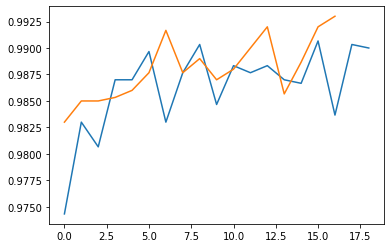

In [12]:
plt.plot(norm_acc)
plt.plot(batch_acc)

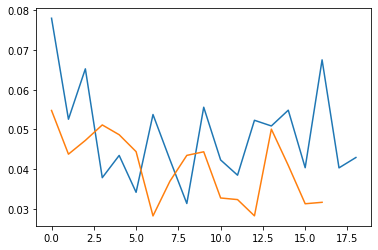

In [13]:
plt.plot(norm_loss)
plt.plot(batch_loss)

## 8.5

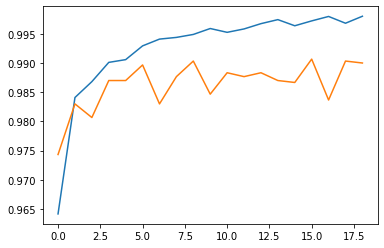

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

Model does seem to be overfitting. Lets add dropout.

In [18]:
model = build_model(**rnd_search_cv.best_params_, dropout=True)

# Checkpoints
checkpoint_cb = keras.callbacks.ModelCheckpoint("chap11_q8_model4.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Train
history_dropout = model.fit(X_train_sub, y_train_sub, epochs=1000,
                    validation_data=(X_valid_sub, y_valid_sub),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Train on 27596 samples, validate on 3000 samples
Epoch 1/1000
27596/27596 [==============================] - 3s 108us/sample - loss: 0.3037 - accuracy: 0.9062 - val_loss: 0.1283 - val_accuracy: 0.9643
Epoch 2/1000
27596/27596 [==============================] - 2s 80us/sample - loss: 0.1434 - accuracy: 0.9606 - val_loss: 0.0893 - val_accuracy: 0.9750
Epoch 3/1000
27596/27596 [==============================] - 2s 80us/sample - loss: 0.1123 - accuracy: 0.9687 - val_loss: 0.0737 - val_accuracy: 0.9780
Epoch 4/1000
27596/27596 [==============================] - 2s 82us/sample - loss: 0.0982 - accuracy: 0.9722 - val_loss: 0.0737 - val_accuracy: 0.9810
Epoch 5/1000
27596/27596 [==============================] - 2s 83us/sample - loss: 0.0832 - accuracy: 0.9773 - val_loss: 0.0574 - val_accuracy: 0.9833
Epoch 6/1000
27596/27596 [==============================] - 2s 78us/sample - loss: 0.0776 - accuracy: 0.9785 - val_loss: 0.0635 - val_accuracy: 0.9823
Epoch 7/1000
27596/27596 [==================

(0.965, 0.9995144426822662)

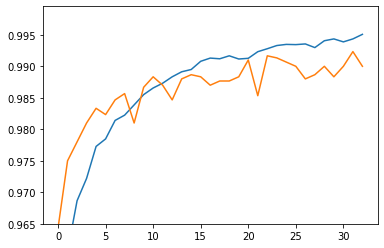

In [22]:
plt.plot(history_dropout.history['accuracy'])
plt.plot(history_dropout.history['val_accuracy'])
plt.ylim(bottom=0.965)

The gap is smaller and the model is probably better.

## Test All 4 Models On Test Set

In [24]:
model_empty = keras.models.load_model("chap11_q8_model2.h5")
model_batch = keras.models.load_model("chap11_q8_model3.h5")
model_dropout = keras.models.load_model("chap11_q8_model4.h5")

models = [model_empty, model_batch, model_dropout]

In [25]:
# Index of 0, 1, 2, 3, 4
idx = (y_test==0)\
    + (y_test==1)\
    + (y_test==2)\
    + (y_test==3)\
    + (y_test==4)
y_test_sub = y_test[idx]
X_test_sub = X_test[idx]

In [32]:
# Print all scores
for model in models:
    y_pred = model.predict_classes(X_test_sub)
    print(model.__class__.__name__, accuracy_score(y_test_sub, y_pred))

Sequential 0.9918272037361354
Sequential 0.9918272037361354
Sequential 0.9931893364467795


Dropout makes improvement!